L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `GaussianLinearCalibration`.

Une difficulté pour valider le résultat est que le modèle de Chaboche n'est que approximativement linéaire.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
def modelChaboche(X):
    strain,R,C,gamma = X
    stress = R + C*(1-np.exp(-gamma*strain))
    return [stress]

In [4]:
g = ot.PythonFunction(4, 1, modelChaboche) 

In [5]:
Strain = ot.Uniform(0,0.07)
unknownR = 750
unknownC = 2750
unknownGamma = 10
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

In [6]:
trueMean = [unknownR,unknownC,unknownGamma]

Create the joint input distribution function.

In [7]:
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

Generate observation noise.

In [8]:
stressObservationNoiseSigma = 40 # (Pa)
observationOutputNoise = ot.Normal(0.,stressObservationNoiseSigma)

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [9]:
R = 700 # Exact : 750
C = 2500 # Exact : 2750
Gamma = 8. # Exact : 10
candidate = ot.Point([R,C,Gamma])

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [10]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, candidate)

## Gaussian linear calibration

The standard deviation of the observations.

In [11]:
sigmaStress = 10. # (Pa)

Define the covariance matrix of the output Y of the model.

In [12]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaStress**2
errorCovariance

class=CovarianceMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[100]

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [13]:
sigmaR = 0.1 * R
sigmaC = 0.1 * C
sigmaGamma = 0.1 * Gamma

In [14]:
parameterCovariance = ot.CovarianceMatrix(3)
parameterCovariance[0,0] = sigmaR**2
parameterCovariance[1,1] = sigmaC**2
parameterCovariance[2,2] = sigmaGamma**2
parameterCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4900,0,0,0,62500,0,0,0,0.64]

In [15]:
size = 100

In [16]:
# 1. Generate exact outputs
inputSample = inputRandomVector.getSample(size)
outputStress = g(inputSample)
# 2. Add noise
sampleNoiseH = observationOutputNoise.getSample(size)
outputObservations = outputStress + sampleNoiseH
# 3. Calibrate
inputObservations = inputSample[:,0]

In [17]:
algo = ot.GaussianLinearCalibration(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)
algo.run()
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [18]:
thetaStarOT = calibrationResult.getParameterMAP()
thetaStarOT

class=Point name=Unnamed dimension=3 values=[740.143,2498.81,11.1546]

In [19]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[740.143,2498.81,11.1546] sigma=class=Point name=Unnamed dimension=3 values=[7.8931,249.78,1.08777] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.947474,-0.956627,0.947474,1,-0.999458,-0.956627,-0.999458,1]

In [20]:
covarianceThetaStarOT = thetaPosterior.getCovariance()
covarianceThetaStarOT

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[62.301,1867.98,-8.21349,1867.98,62390.1,-271.556,-8.21349,-271.556,1.18325]

## Create an empirical sample of theta

Sample theta from its gaussian prior. Keep only the ones leading to predictions close to observations.

In [21]:
priorTheta = ot.Normal(candidate,parameterCovariance)
priorTheta

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[700,2500,8] sigma=class=Point name=Unnamed dimension=3 values=[70,250,0.8] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0,0,0,1,0,0,0,1]

In [22]:
parameterDimension = priorTheta.getDimension()
descr = ["R","C","Gamma"]

In [30]:
resampleSize = 40000 # Number of Theta realization to create
sampleTheta = ot.Sample(resampleSize,parameterDimension)
sampleTheta.setDescription(descr)
sampleDistance = ot.Sample(resampleSize,1)
epsilon = size # Maximum euclidian norm absolute deviation between observations and predictions
for i in range(resampleSize):
    thetaRealization = priorTheta.getRealization()
    model.setParameter(thetaRealization)
    predictions = model(inputObservations)
    residual = predictions.asPoint()-outputObservations.asPoint()
    sampleTheta[i] = thetaRealization
    sampleDistance[i,0] = residual.norm()

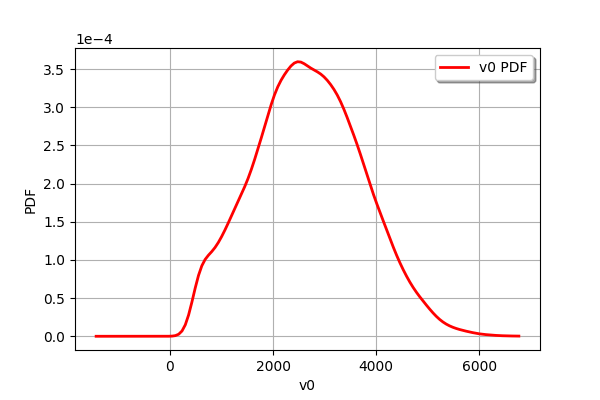

In [31]:
ksd = ot.KernelSmoothing().build(sampleDistance)
ksd.drawPDF()

In [34]:
probabilityThreshold = 0.01 # The probability of having a small discrepancy
epsilon = ksd.computeQuantile(probabilityThreshold)[0]
epsilon

515.4514142861335

In [35]:
conditionalSampleIndex = 0 # Number of Theta achieving the criteria
for i in range(resampleSize):
    if (sampleDistance[i,0]<epsilon):
        conditionalSampleIndex += 1
conditionalSampleSize = conditionalSampleIndex
conditionalSampleSize

272

In [36]:
conditionalSampleIndex = 0 # Number of Theta achieving the criteria
conditionalSample = ot.Sample(conditionalSampleSize,parameterDimension)
for i in range(resampleSize):
    if (sampleDistance[i,0]<epsilon):
        conditionalSample[conditionalSampleIndex] = sampleTheta[i]
        conditionalSampleIndex += 1

## Draw distributions

In [37]:
import pylab as pl
import openturns.viewer as otv

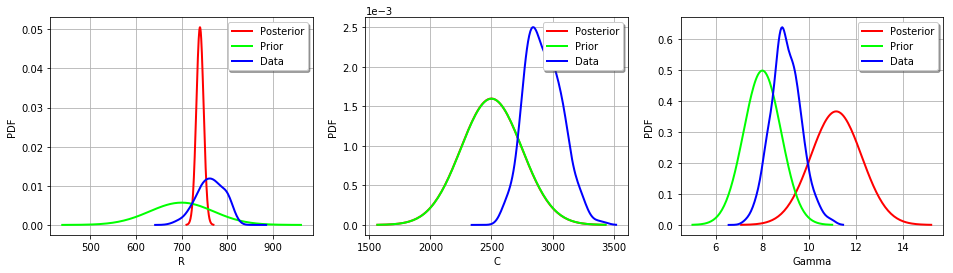

In [38]:
fig = pl.figure(figsize=(16, 4))
for i in range(parameterDimension):
    thetai = thetaPosterior.getMarginal(i)
    graph = thetai.drawPDF()
    graph.setXTitle(descr[i])
    # From prior
    thetaiPriorGraph = priorTheta.getMarginal(i).drawPDF()
    thetaiPriorGraph.setColors(["green"])
    graph.add(thetaiPriorGraph)
    # From data
    sampleMargin = conditionalSample.getMarginal(i)
    ksdist = ot.KernelSmoothing().build(sampleMargin).drawPDF()
    ksdist.setColors(["blue"])
    graph.add(ksdist)
    graph.setLegends(["Posterior","Prior","Data"])
    ax = fig.add_subplot(1, parameterDimension, i+1)
    _ = otv.View(graph, figure=fig, axes=[ax])

On observe que la loi à posteriori ne correspond pas à la loi des données. La cause de ce problème est peut-etre que le modèle n'est pas exactement linéaire.